In [470]:
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [471]:
train = pd.read_csv('data/train.csv', index_col=0)
print(train.shape)
train.head()

(37518, 3)


,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5


In [472]:
test = pd.read_csv('data/test.csv', index_col=0)
print(test.shape)
test.head()

(7125, 3)


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini


In [473]:
all_data = pd.concat([train, test], axis=0)

In [474]:
# Доля тест во всей выборке
sum(all_data['user_word'].notnull()) / all_data['user_word'].shape[0] 

0.1595994892816343

In [475]:
all_data['ts'] = pd.to_datetime(all_data['ts'])

<Axes: >

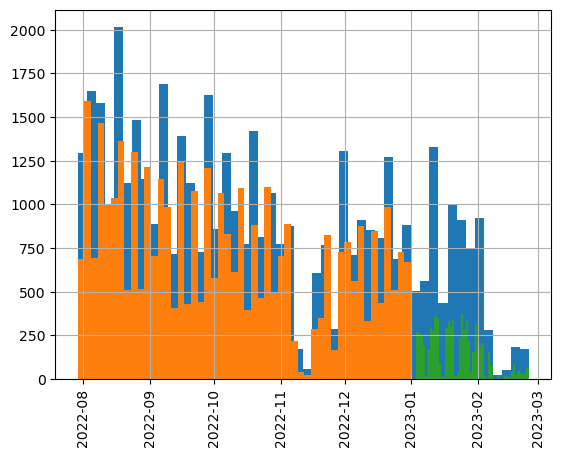

In [502]:
plt.figure()
plt.xticks(rotation='vertical')
all_data['ts'].hist(bins=50)
train['ts'].hist(bins=50)
test['ts'].hist(bins=50)


<Axes: >

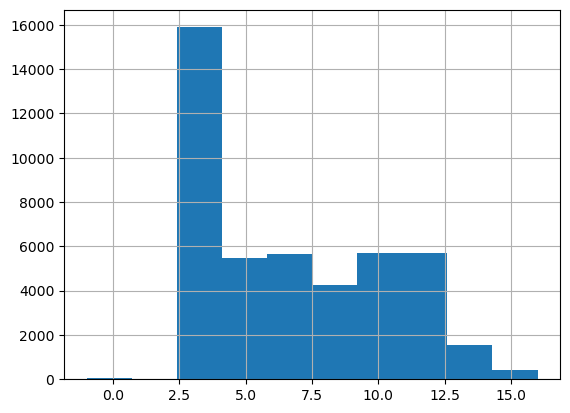

In [477]:
all_data["gate_id"].hist()

In [478]:
all_data[all_data["gate_id"] == 3].shape

(6260, 4)

# Here we continue

In [479]:
train_gate_list = sorted(list(train['gate_id'].unique()))
test_gate_list = sorted(list(test['gate_id'].unique()))

only_train = [gate for gate in train_gate_list if gate not in test_gate_list]
only_test = [gate for gate in test_gate_list if gate not in train_gate_list]

print("Only train gates: ", " ".join(map(str, only_train)))
print("Only test gates: ", " ".join(map(str, only_test)))

Only train gates:  0 16
Only test gates:  2


In [480]:
test[test['gate_id']==2]

,ts,gate_id,user_word
39911,2023-01-13 16:49:52,2,categorical
39912,2023-01-13 16:49:54,2,categorical
39928,2023-01-13 18:21:16,2,categorical
39929,2023-01-13 18:21:19,2,categorical


In [481]:
#1st transformation
#Adding dummies for gates

gates = pd.get_dummies(all_data['gate_id'])
gates.columns = ["gate_" + str(col) for col in gates.columns]
all_data = pd.concat([all_data, gates], axis=1)

all_data.head(1)

,user_id,ts,gate_id,user_word,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,gate_7,gate_8,gate_9,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16
0,18.0,2022-07-29 09:08:54,7,NaN,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [482]:
#2nd transformation
#Adding dummies for days of week


days_of_week = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
all_data[days_of_week] = pd.get_dummies(all_data['ts'].dt.day_name())[days_of_week]

In [483]:
#3rd transformation
#Time

all_data['hour'] = all_data['ts'].dt.hour
all_data['minute'] = all_data['ts'].dt.minute


hours = pd.get_dummies(all_data['ts'].dt.hour)
hours.columns = ["h_" + str(col) for col in hours.columns]
all_data = pd.concat([all_data, hours], axis=1)

In [484]:
# 4th transformation
# Working and not working days

all_data["date"] = all_data["ts"].dt.date
count = all_data.groupby("date").size().reset_index(name='count')
result = pd.merge(all_data, count, on='date', how='left')

result["is_weekend"] = result["count"] < 100
result.drop(["count", "date"], axis=1, inplace=True)

all_data = result


In [485]:
# 5th transformation
# Check for gate halves

all_data["gate_half"] = all_data["gate_id"] <= 8


In [ ]:
# 6th transformation
# time id

In [486]:
print(all_data.columns, len(all_data.columns))

Index(['user_id', 'ts', 'gate_id', 'user_word', 'gate_-1', 'gate_0', 'gate_1',
       'gate_2', 'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8',
       'gate_9', 'gate_10', 'gate_11', 'gate_12', 'gate_13', 'gate_14',
       'gate_15', 'gate_16', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'hour', 'minute', 'h_0', 'h_1', 'h_3',
       'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14',
       'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21', 'h_22', 'h_23',
       'is_weekend', 'gate_half'],
      dtype='object') 54


In [487]:
train['ts'].agg(['max','count'])

max      2022-12-31 20:39:31
count                  37518
Name: ts, dtype: object

In [488]:
test['ts'].agg(['min','max','count'])

min      2023-01-03 08:21:00
max      2023-02-24 19:44:09
count                   7125
Name: ts, dtype: object

# Val index

In [489]:
# Подготовим данные для train, test

train_idx = all_data['user_word'].isnull()

train = all_data.loc[train_idx]
test = all_data.loc[~train_idx]

In [490]:
# Подготовим данные для train, validation из train
val_index = train['ts'] > '2022-11-30'

X = train[~val_index].copy()
X_val = train[val_index].copy()

y = X['user_id'].astype(int)
y_val = X_val['user_id'].astype(int)

#Доля на валидации
sum(val_index) / val_index.shape[0]

0.18612399381630151

In [491]:
# # Подсчитаем, сколько у нас каждых чубриков
# count = X.groupby("user_id").size().reset_index(name='count')
# X = pd.merge(X, count, on='user_id', how='left')


# count = X_val.groupby("user_id").size().reset_index(name='count')
# X_val = pd.merge(X_val, count, on='user_id', how='left')

In [492]:
X.drop(['user_id', 'ts', 'gate_id', 'user_word'], axis=1, inplace=True)
X_val.drop(['user_id', 'ts', 'gate_id', 'user_word'], axis=1, inplace=True)

X.columns

Index(['gate_-1', 'gate_0', 'gate_1', 'gate_2', 'gate_3', 'gate_4', 'gate_5',
       'gate_6', 'gate_7', 'gate_8', 'gate_9', 'gate_10', 'gate_11', 'gate_12',
       'gate_13', 'gate_14', 'gate_15', 'gate_16', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour',
       'minute', 'h_0', 'h_1', 'h_3', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10',
       'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19',
       'h_20', 'h_21', 'h_22', 'h_23', 'is_weekend', 'gate_half'],
      dtype='object')

In [493]:
X.columns


Index(['gate_-1', 'gate_0', 'gate_1', 'gate_2', 'gate_3', 'gate_4', 'gate_5',
       'gate_6', 'gate_7', 'gate_8', 'gate_9', 'gate_10', 'gate_11', 'gate_12',
       'gate_13', 'gate_14', 'gate_15', 'gate_16', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour',
       'minute', 'h_0', 'h_1', 'h_3', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10',
       'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19',
       'h_20', 'h_21', 'h_22', 'h_23', 'is_weekend', 'gate_half'],
      dtype='object')

In [494]:
# Сделаем нормирование 

scaler_X = StandardScaler()
scaler_X_val = StandardScaler()

scaler_X.fit(X)
scaler_X_val.fit(X_val)

X_scaled = scaler_X.transform(X)
X_val_scaled = scaler_X_val.transform(X_val)

### Учим модель

In [495]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [496]:
#clf = LogisticRegression(solver='saga').fit(X_scaled, y)
clf = RandomForestClassifier().fit(X_scaled, y)

y_pred = clf.predict(X_scaled)

y_val_pred = clf.predict(X_val_scaled)

### Оцениваем качество

In [497]:
# Делаем валидацию нашей модель

# Создаем новые датасеты
y_word = pd.DataFrame()
y_val_word = pd.DataFrame()

# Что типа id в тестовой выборке
y_word['word'] = 'user_' + y.astype(str)
y_val_word['word'] = 'user_' + y_val.astype(str) 

# Целевая переменная ground truth
y_word['true'] = y
y_val_word['true'] = y_val

# Добавим предсказания
y_word['preds'] = y_pred
y_val_word['preds'] = y_val_pred



# Делаем датасеты с предсказаниями
y_pred_word = pd.DataFrame(y_word.groupby('word')[['true','preds']].agg(lambda x: x.value_counts().index[0]))
y_val_pred_word = pd.DataFrame(y_val_word.groupby('word')[['true','preds']].agg(lambda x: x.value_counts().index[0]))

# Добавляем сравнение с ground truth
y_pred_word['comp'] = y_pred_word['preds'] == y_pred_word['true']
y_val_pred_word['comp'] = y_val_pred_word['preds'] == y_val_pred_word['true']


# Веса юзеров мы не знаем, давайте возьмем равные веса для простоты = 1. Можно и не брать пролли
y_pred_word['norm'] = 1
y_val_pred_word['norm'] = 1


In [498]:
# Оцениваем на train

true_answers = (y_pred_word['comp'] * y_pred_word['norm']).sum()
total_answers = y_pred_word['norm'].sum()
precent_true = round((true_answers/total_answers)*100, 1)

print('Оценка train2', true_answers, total_answers, precent_true)

Оценка train2 49 50 98.0


In [499]:
# Оцениваем на val

true_answers_val = (y_val_pred_word['comp'] * y_val_pred_word['norm']).sum()
total_answers_val = y_val_pred_word['norm'].sum()
precent_true_val = round((true_answers_val/total_answers_val)*100, 1)

print('Оценка val', true_answers_val, total_answers_val, precent_true_val)

Оценка val 8 43 18.6


### Готовим сабмит

In [422]:
X_train = train.copy()
y_train = X_train['user_id'].astype(int)
X_test = test.copy()
X_test.head()

,user_id,ts,gate_id,user_word,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,is_weekend
37518,NaN,2023-01-03 08:21:00,9,gini,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37519,NaN,2023-01-03 08:21:00,9,gini,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37520,NaN,2023-01-03 08:21:18,5,gini,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37521,NaN,2023-01-03 08:21:19,5,gini,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37522,NaN,2023-01-03 08:21:39,10,gini,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [423]:
# # Подсчитаем, сколько у нас каждых чубриков
# count = X_train.groupby("user_id").size().reset_index(name='count')
# X_train = pd.merge(X_train, count, on='user_id', how='left')

# count = X_test.groupby("user_word").size().reset_index(name='count')
# X_test = pd.merge(X_test, count, on='user_word', how='left')

In [424]:
X_train.drop(['user_id', 'ts', 'gate_id', 'user_word'], axis=1, inplace=True)
X_test.drop(['user_id', 'ts', 'gate_id', 'user_word'], axis=1, inplace=True)

In [425]:
# Сделаем нормирование отдельными скейлерами по X и по X_test, т.к. будущие данные скорее всего изменятся

scaler_X_train = StandardScaler()
scaler_X_test = StandardScaler()

scaler_X_train.fit(X_train)
scaler_X_test.fit(X_test)

X_train_scaled = scaler_X_train.transform(X_train)
X_test_scaled = scaler_X_test.transform(X_test)

In [430]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

clf = CatBoostClassifier().fit(X_train_scaled, y_train)

y_train_pred = clf.predict(X_train_scaled)

y_test_pred = clf.predict(X_test_scaled)

Learning rate set to 0.095194
0:	learn: 3.8768936	total: 279ms	remaining: 4m 38s
1:	learn: 3.7798124	total: 400ms	remaining: 3m 19s
2:	learn: 3.6915337	total: 520ms	remaining: 2m 52s
3:	learn: 3.6143870	total: 635ms	remaining: 2m 38s
4:	learn: 3.5524995	total: 769ms	remaining: 2m 32s
5:	learn: 3.5028618	total: 889ms	remaining: 2m 27s
6:	learn: 3.4629991	total: 1.01s	remaining: 2m 23s
7:	learn: 3.4270128	total: 1.13s	remaining: 2m 20s
8:	learn: 3.3974851	total: 1.25s	remaining: 2m 17s
9:	learn: 3.3696697	total: 1.37s	remaining: 2m 15s
10:	learn: 3.3415911	total: 1.48s	remaining: 2m 13s
11:	learn: 3.3118923	total: 1.59s	remaining: 2m 11s
12:	learn: 3.2891309	total: 1.71s	remaining: 2m 9s
13:	learn: 3.2656766	total: 1.82s	remaining: 2m 8s
14:	learn: 3.2489218	total: 1.93s	remaining: 2m 7s
15:	learn: 3.2286702	total: 2.05s	remaining: 2m 6s
16:	learn: 3.2115332	total: 2.2s	remaining: 2m 7s
17:	learn: 3.1991377	total: 2.34s	remaining: 2m 7s
18:	learn: 3.1866405	total: 2.48s	remaining: 2m 7s


In [427]:
clf.feature_importances_

array([1.05442271e-03, 5.45996569e-05, 1.15000705e-04, 0.00000000e+00,
       4.93049659e-03, 7.76221121e-03, 5.82761912e-03, 4.31692536e-03,
       6.12608048e-03, 1.05406750e-03, 5.47951557e-03, 6.22062020e-03,
       6.45932681e-03, 6.36471165e-03, 7.23756735e-03, 2.19449315e-05,
       3.70019496e-03, 1.01076877e-04, 1.40715699e-02, 1.26874757e-02,
       1.32507511e-02, 1.38833062e-02, 1.30001809e-02, 6.15115679e-03,
       2.49907017e-03, 2.20214300e-02, 7.86000764e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.78567839e-05, 8.97052131e-04,
       2.56244803e-03, 3.10293270e-03, 2.99780528e-03, 3.34571594e-03,
       3.04274061e-03, 3.07824819e-03, 3.32071586e-03, 3.13387907e-03,
       3.28696802e-03, 3.24280699e-03, 2.91829561e-03, 2.74562532e-03,
       2.25382803e-03, 2.01103090e-03, 7.92186720e-04, 6.52606665e-04,
       6.13517045e-03])

In [428]:
test_words = pd.DataFrame()

test_words['user_word'] = test['user_word']
test_words['preds'] = y_test_pred

comp_df_test = pd.DataFrame(test_words.groupby('user_word')['preds'].agg(lambda x: x.value_counts().index[0]))

comp_df_test.to_csv('answer.csv') 


In [162]:
! zip answer.zip answer.csv # Подготовка файла для отправки

'zip' is not recognized as an internal or external command,
operable program or batch file.
